In [1]:
import pandas as pd
import numpy as np
import re
import string

import seaborn as sns 
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=DATASET_COLUMNS)

In [22]:
df.sample(6)

,target,ids,date,flag,user,text
52397,0,1679446889,Sat May 02 09:22:35 PDT 2009,NO_QUERY,DivasMistress,ty to those who sent out the tweets abt my loc...
677613,0,2248744155,Fri Jun 19 21:06:45 PDT 2009,NO_QUERY,stephk77,@ddlovato I know! It's so sad what people do t...
1238058,4,1993164438,Mon Jun 01 09:56:10 PDT 2009,NO_QUERY,nickdennis,@dajbelshaw What are you doing on the 24th Jun...
537105,0,2198637940,Tue Jun 16 16:21:28 PDT 2009,NO_QUERY,AmanduhRae,"@natalieeeg actually, i did! i dont think they..."
347953,0,2016628171,Wed Jun 03 07:05:58 PDT 2009,NO_QUERY,mr_apollo,@misserika thats why i was up til like damn ne...
1096368,4,1970308562,Sat May 30 03:19:34 PDT 2009,NO_QUERY,booshtukka,@Smeegazzle You back?


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [24]:
df.nunique()

target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

In [25]:
df = df[["target","text"]]
df.sample(5)

,target,text
1562076,4,@antheia I want to see this
454406,0,2pm I am now officially dreading tomorrow (of...
1534159,4,i have joint pain so bad the past few days hen...
586928,0,Looks like it's going to rain!!! I just washe...
1190667,4,@SlimPerfect Thanks! It does look good. Having...


In [26]:
df.target.unique()

array([0, 4])

In [28]:
df.target = df['target'].replace(4,1)

In [29]:
df.target.unique()

array([0, 1])

In [30]:
df.sample(5)

,target,text
599728,0,@Blonde_M I don't think that's the most effici...
1126533,1,@HeartlandGifts I know sure makes things easie...
856472,1,getting ready for a long day at work!!
353329,0,Walking to Subway for lunch was a form of tort...
1283999,1,"ah, claro, bom dia, twitter"


In [32]:
df.shape

(1600000, 2)

In [33]:
df['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

Negative    800000
Positive    800000
Name: target, dtype: int64


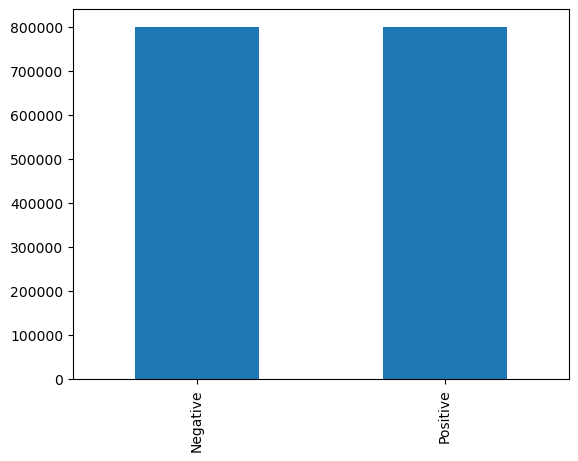

In [34]:
sentiment= {0:'Negative', 1:'Positive'}
print(df['target'].apply(lambda x: sentiment[x]).value_counts())
df['target'].apply(lambda x: sentiment[x]).value_counts().plot(kind='bar')
plt.show()

In [35]:
data =  df[["text", 'target']]
data.head(2)

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0


<Axes: >

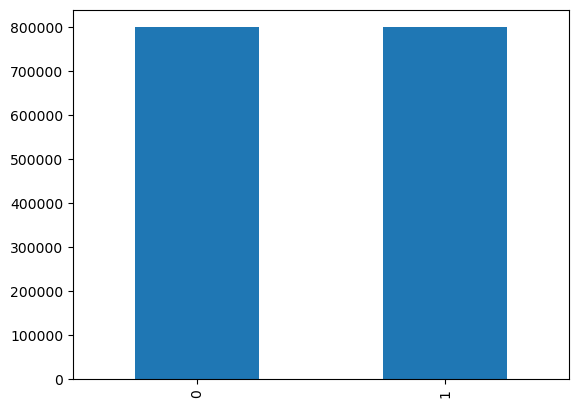

In [36]:
df['target'].value_counts().plot(kind='bar')

In [37]:
data_pos = data[data['target']==1].sample(50000, random_state=42)
data_neg = data[data['target']==0].sample(50000, random_state=42)

dataset = pd.concat([data_pos, data_neg])
print(len(dataset))
dataset.sample(3)

100000


,text,target
1211928,Our zone is on twitter!This is a great way for...,1
1344254,"@burgess_mark Fine, suit yourself. Don't come ...",1
1273485,day off. beach tomorrow also finished my fir...,1


In [38]:
dataset["text"]= dataset['text'].str.lower()
dataset.text.sample(4)

1000345    oh damn i think i've just been hit by the twit...
1046833                           @mandyyjirouxx good night 
27739                                        comfort eating 
635075               @daynahaines noooo!   how do you know?!
Name: text, dtype: object

In [40]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
len(stopwordlist)

136

In [41]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset["text"].apply(lambda text: cleaning_stopwords(text))
dataset.text.tail()

299543     @jendearness @bjwysoske not forwarded. think it.
746432                                  @sonicphotonic yeah
256034    i'm sooo burnt remind take suncream next time ...
428114    @ronskanky applied weeks ago but didn't hear a...
491974    phone killing itself, ipod, gorgeous smashed s...
Name: text, dtype: object

In [52]:
tweet_tokens = word_tokenize('text')
stopword_list = nltk.corpus.stopwords.words('english')
stop = set(stopwords.words('english'))
print('NLTK stop word lists \n')
print(stop)
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens if token not in  stopword_list]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    

NLTK stop word lists 

{"that'll", 'under', 'until', 'doing', 'm', 'shouldn', 'in', 'of', 'who', 'haven', "didn't", 'same', 'on', 'during', 'be', 'below', 'ourselves', 'shan', 'theirs', "isn't", 'both', 'are', 'wasn', "shouldn't", 'don', 'those', 'few', 'he', 'i', 'some', "you're", 'or', 'ain', 'by', "don't", 'aren', 'that', 'too', "needn't", 'me', 'him', 'yourselves', "mustn't", 'her', 'having', 'wouldn', 'o', 'ma', 'y', "she's", 'we', 'so', 'again', 'the', "you'd", 'but', 'into', 'now', 'here', 'then', 'such', "hasn't", 'ours', "wouldn't", "mightn't", 'you', 'only', 'd', 'down', "weren't", 'is', 'doesn', 'once', 'themselves', 'against', 'his', 'why', 'they', 'can', 'a', 'were', 'hadn', 'my', 'needn', 'myself', 'was', 'been', 'itself', 'for', 'no', 'these', 's', 'after', 'has', 'before', 'up', 'mightn', 'further', 'have', 't', 'if', 'all', 'than', 'above', "won't", "it's", 'this', 'to', 'our', 'herself', 've', 'won', 'an', "aren't", 'each', 'does', 'their', "couldn't", 'what', 'had', 

In [54]:
 filtered_words = [word for word in tweet_tokens if word not in stop_words]
data.text.tail()

1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, dtype: object

In [56]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x:  cleaning_URLs(x))
dataset['text'].head(5)

1012188    lookin 4ward long weekend really dont want go ...
1099036              #myweakness music live meet people make
1275978                            figured internet new ipod
1388988    @hillsongunited can't wait worship guys tonigh...
938859     @sillybeggar congrats james !! i'm sure book g...
Name: text, dtype: object

In [57]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x : cleaning_numbers(x))
dataset['text'].head(5)

1012188    lookin ward long weekend really dont want go w...
1099036              #myweakness music live meet people make
1275978                            figured internet new ipod
1388988    @hillsongunited can't wait worship guys tonigh...
938859     @sillybeggar congrats james !! i'm sure book g...
Name: text, dtype: object

In [59]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, '', input_txt)
    return input_txt

In [60]:
dataset["text"] = np.vectorize(remove_pattern)(dataset['text'], "@[\w]*")
dataset['text'].head()

1012188    lookin ward long weekend really dont want go w...
1099036              #myweakness music live meet people make
1275978                            figured internet new ipod
1388988      can't wait worship guys tonight. it'll much fun
938859      congrats james !! i'm sure book going huge su...
Name: text, dtype: object

In [61]:
dataset["text"] = dataset['text'].str.replace("[^a-zA-Z#]", " ")
dataset.head(5)

,text,target
1012188,lookin ward long weekend really dont want go w...,1
1099036,#myweakness music live meet people make,1
1275978,figured internet new ipod,1
1388988,can t wait worship guys tonight it ll much fun,1
938859,congrats james i m sure book going huge su...,1


In [62]:
dataset['text'] = dataset['text'].apply(lambda x: 
                    " ".join([w for w in x.split() if len(w)>3]))
dataset.head()

,text,target
1012188,lookin ward long weekend really dont want work,1
1099036,#myweakness music live meet people make,1
1275978,figured internet ipod,1
1388988,wait worship guys tonight much,1
938859,congrats james sure book going huge success,1


In [66]:
def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http/S + www/S + http/S", " ", tweet, flags = re.MULTILINE)
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    tweet = re.sub(r'\@\w+|\#', "", tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [word for word in tweet_tokens if word not in stop_words]
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    return " ".join(lemma_words)

In [67]:
dataset.head()

,text,target
1012188,lookin ward long weekend really dont want work,1
1099036,#myweakness music live meet people make,1
1275978,figured internet ipod,1
1388988,wait worship guys tonight much,1
938859,congrats james sure book going huge success,1


In [68]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

1012188    lookin ward long weekend really dont want work
1099036           #myweakness music live meet people make
1275978                             figured internet ipod
1388988                    wait worship guys tonight much
938859        congrats james sure book going huge success
Name: text, dtype: object

In [69]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
def lemmatize_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return ' '.join(text)
dataset['text'] = dataset['text'].apply(lambda x: lemmatize_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_d

1012188    l o o k i n   w a r d   l o n g   w e e k e n ...
1099036    # m y w e a k n e s s   m u s i c   l i v e   ...
1275978            f i g u r e d   i n t e r n e t   i p o d
1388988    w a i t   w o r s h i p   g u y s   t o n i g ...
938859     c o n g r a t s   j a m e s   s u r e   b o o ...
Name: text, dtype: object

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=1200)
vectorized_data = count_vectorizer.fit_transform(df['text']).toarray()

y= df['target']

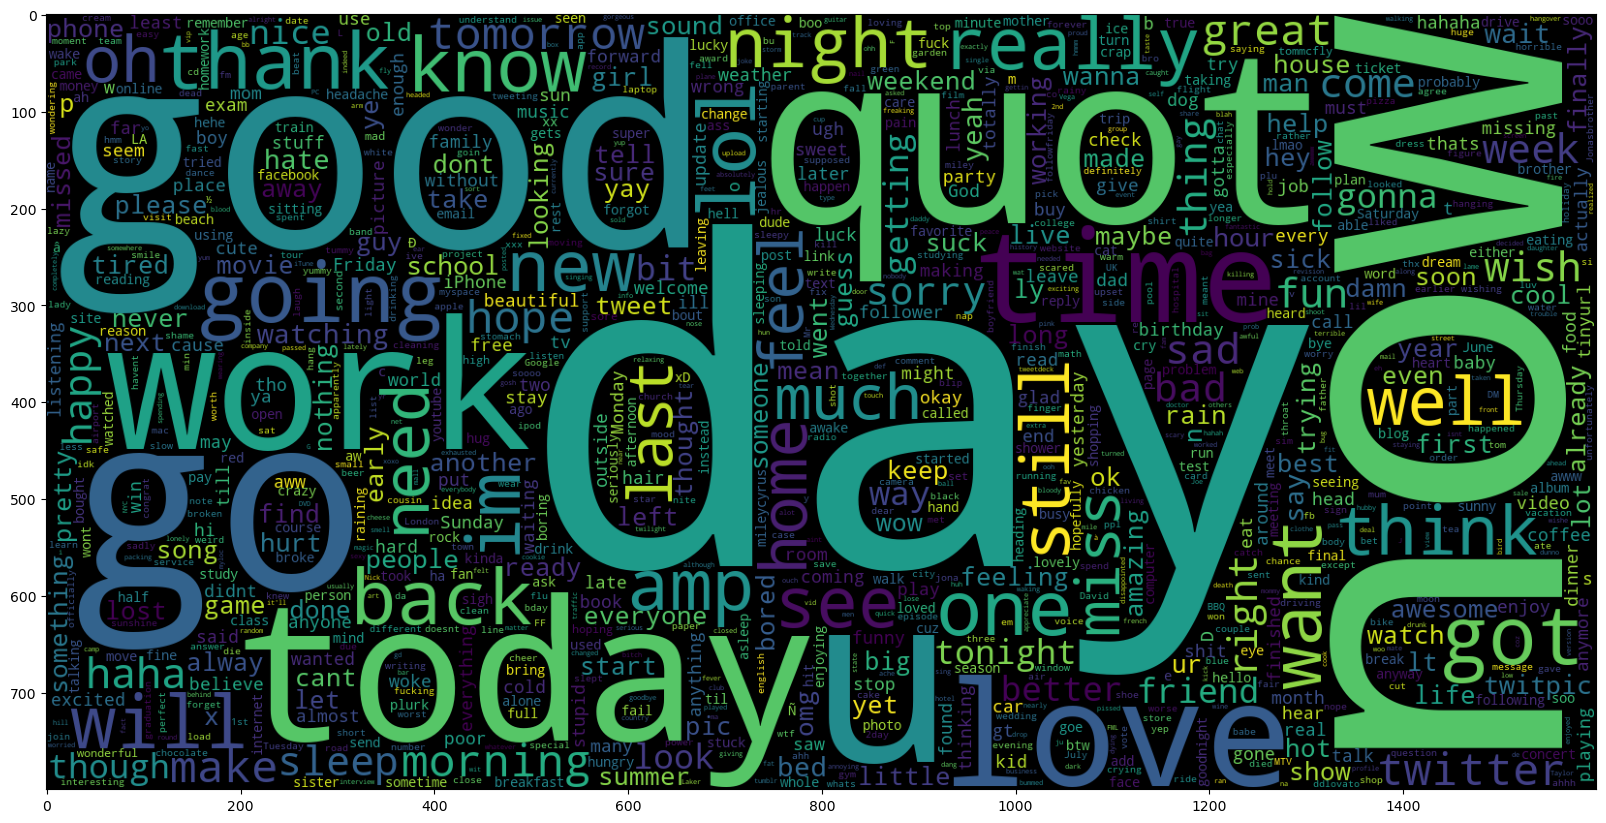

In [81]:
from wordcloud import WordCloud
data_neg = df['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [89]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [90]:
X=df['text']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =42)

In [91]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [93]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [94]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80    159494
           1       0.80      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



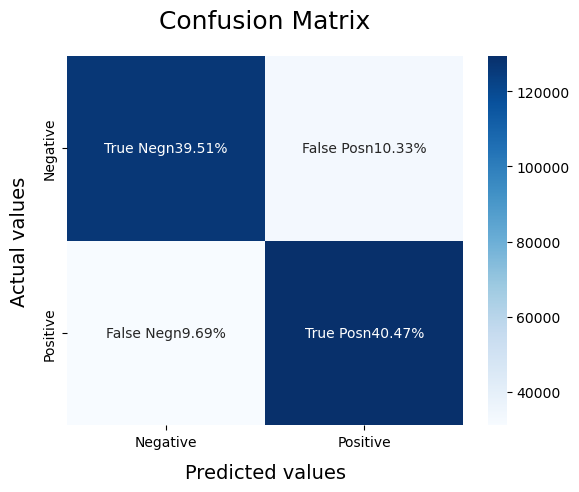

In [95]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159494
           1       0.81      0.82      0.82    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



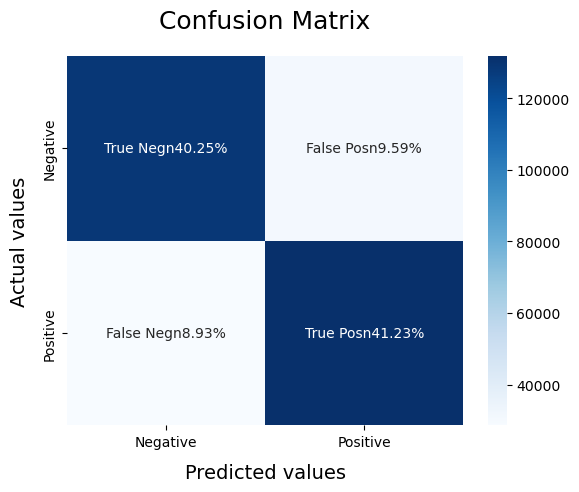

In [96]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159494
           1       0.82      0.83      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



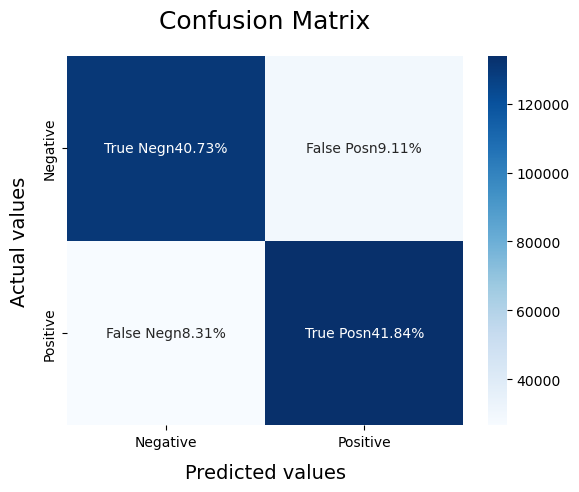

In [97]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [98]:
from sklearn.naive_bayes import ComplementNB

In [99]:
naive_model = ComplementNB().fit(X_train,y_train)

In [100]:
predictions = naive_model.predict(X_test)

In [103]:
from sklearn.metrics import confusion_matrix,classification_report

In [104]:
print(confusion_matrix(predictions,y_test))

[[130823  33749]
 [ 28671 126757]]


In [105]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81    164572
           1       0.79      0.82      0.80    155428

    accuracy                           0.80    320000
   macro avg       0.80      0.81      0.80    320000
weighted avg       0.81      0.80      0.80    320000

